In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
# !pip install -U keras
# !pip install tensorflow-gpu==2.1.0rc0

In [ ]:
PATH = "/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays/HER2/Ground Truth/IHC 232.npy"
SAVE = "/content/drive/My Drive/Breast Cancer Treatment/Images for Paper/HER2/"
img = np.load(PATH)
cv2.imwrite(SAVE + 'HER2 232 GT.png', img[0])


True

In [4]:
PATH = "/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays/Predicted Output/HER2/3Fold UNET/Fold 0/Train/229.npy"
# PATH = "/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays/4 Class PR/Masks/IHC 263.npy"
SAVE = "/content/drive/My Drive/Breast Cancer Treatment/Images for Paper/HER2/"
imgs = np.load(PATH)
cv2.imwrite(SAVE + "HER2 229 UNET.png", imgs[0])

True

In [ ]:
import os
import cv2
import math
import numpy as np
from skimage import measure
from skimage.measure import regionprops
from skimage.morphology import erosion,opening, disk
from scipy.stats import mode
import matplotlib.pyplot as plt

In [ ]:
def postprocess(image):

  # Opening operation
  selem = disk(15)
  opened = opening(image, selem)

  # Removing small pixel patches
  nuclei = measure.label(opened)
  props = regionprops(nuclei)

  for i in range(len(props)):
    if props[i].area <= 400:
      opened[nuclei == nuclei[i]] = 0

  return opened

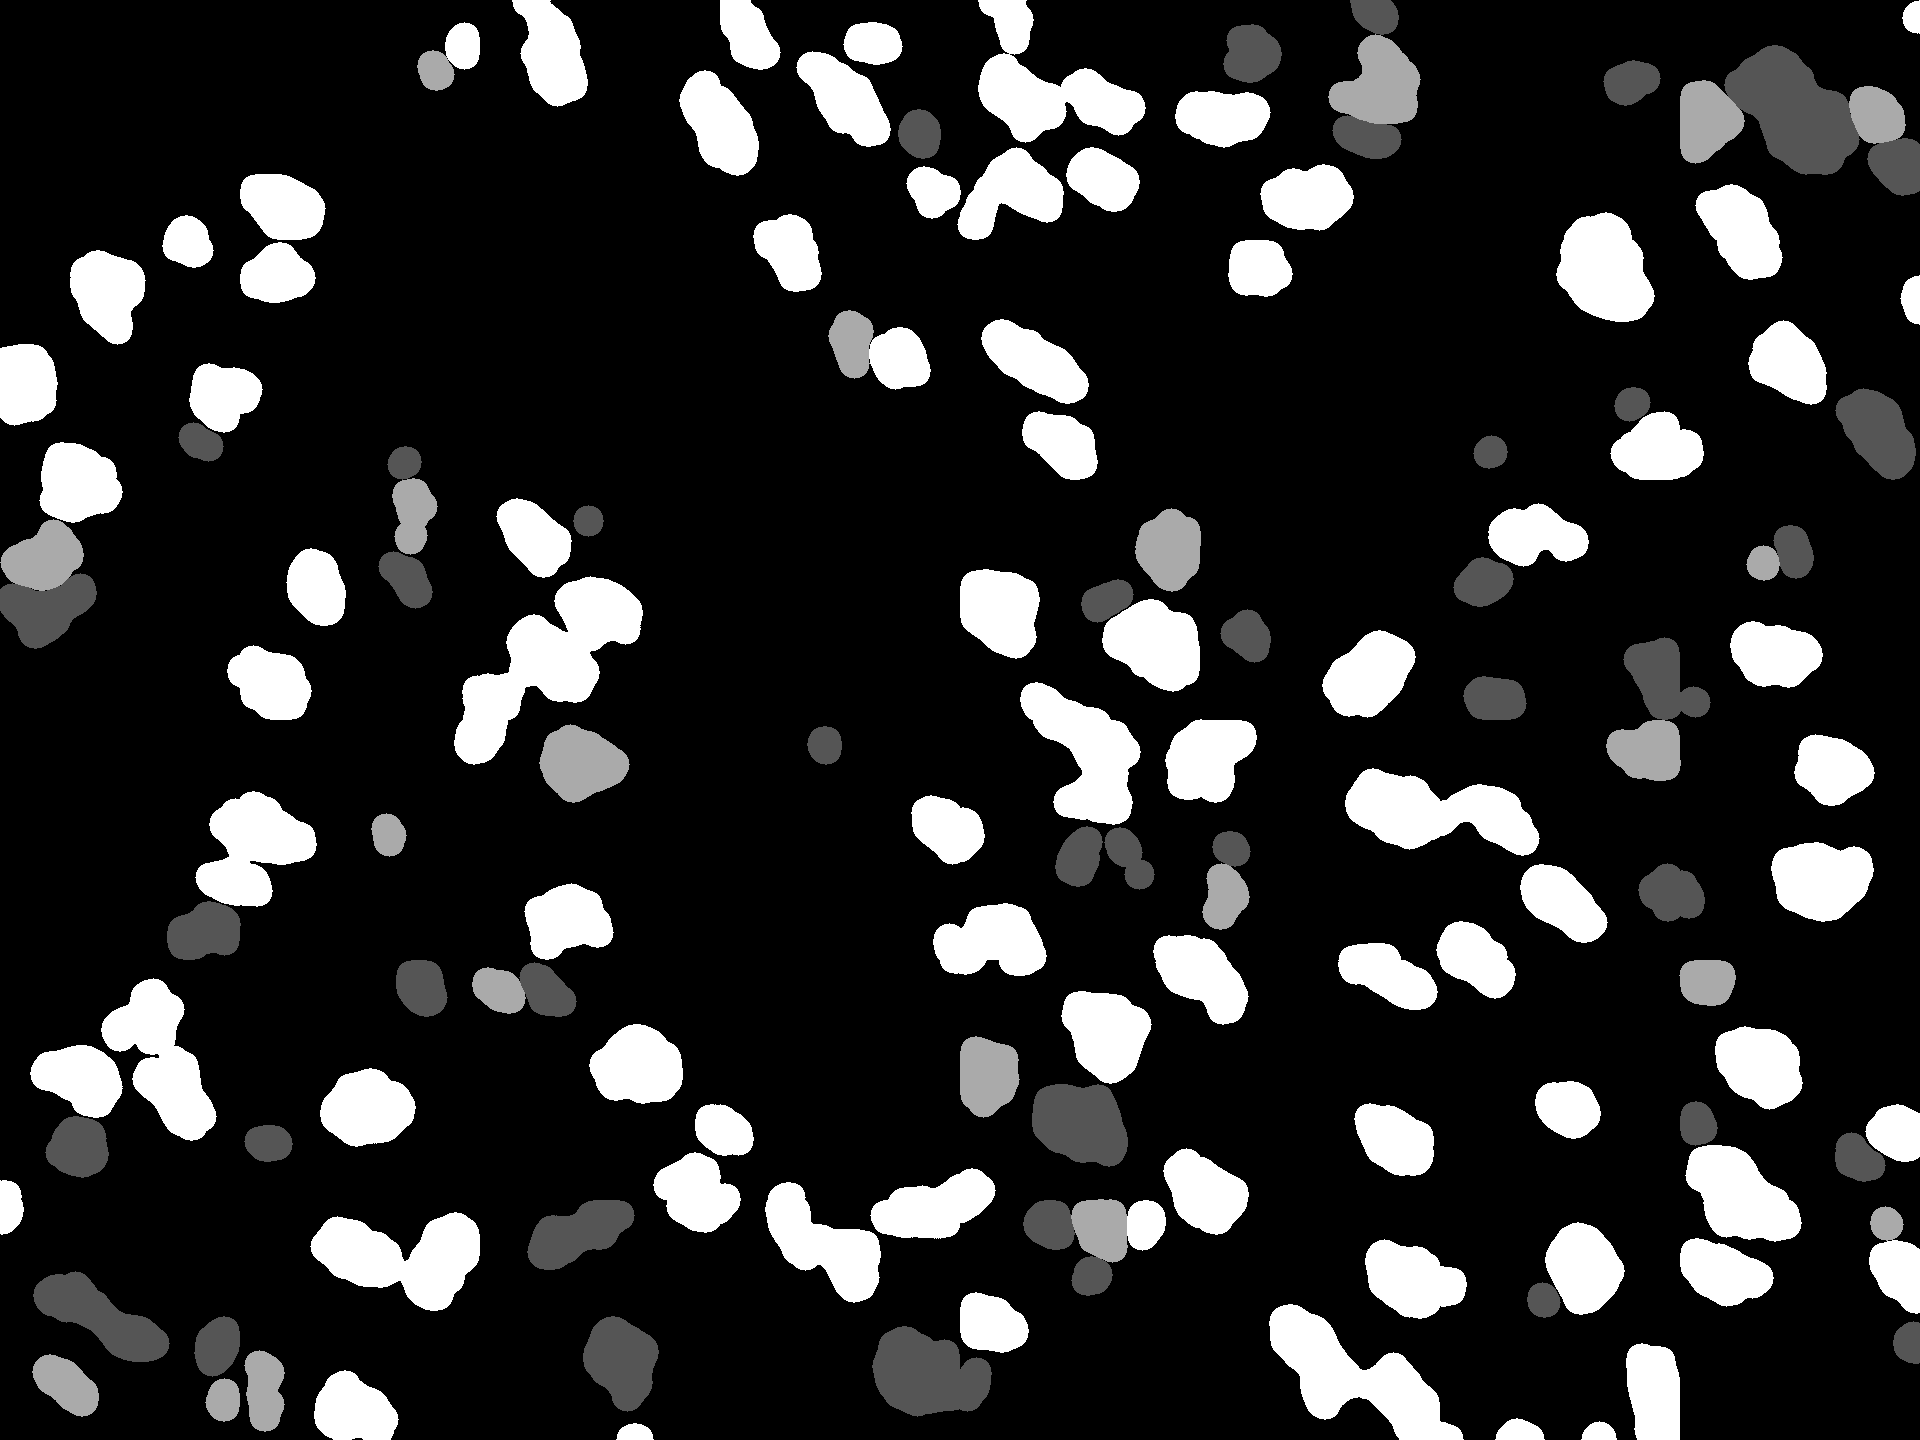

In [ ]:
from google.colab.patches import cv2_imshow
strong = np.copy(imgs[0])
strong[strong==85]=0
strong[strong==170]=0
res1 = postprocess(strong)

i = np.copy(imgs[0])
i[i==85]=0
i[i==255]=0
res2 = postprocess(i)

w = np.copy(imgs[0])
w[w==255]=0
w[w==170]=0
res3 = postprocess(w)

res = res1 + res2 + res3
cv2_imshow(res)

In [ ]:
cv2.imwrite(SAVE + "After postprocessing.png", res)

True

In [ ]:
import math
import random
import keras
from keras.layers import *
from keras.models import Sequential
from keras import Model
from keras import backend as K  
from keras.regularizers import l2

Using TensorFlow backend.


In [ ]:
def get_conv_block(input_layer,nFilters,size):
    conv1 = Conv2D(nFilters, size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=l2(1e-4))(input_layer)
    bn1 = BatchNormalization()(conv1)
    conv2 = Conv2D(nFilters, size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=l2(1e-4))(bn1)
    bn2 = BatchNormalization()(conv2)
    return bn2
    
def get_UNET(input_layer,nFilters,flag): 

    block1 = get_conv_block(input_layer[0],nFilters,3)
    mp1 = MaxPooling2D(pool_size=(2, 2))(block1)
    dr1 = Dropout(0.1)(mp1)
   
    if(flag==1):
      dr1 = concatenate([dr1,input_layer[1]])

    block2 = get_conv_block(dr1,nFilters*2,3)
    mp2 = MaxPooling2D(pool_size=(2, 2))(block2)
    dr2 = Dropout(0.1)(mp2)

    if(flag==1):
      dr2 = concatenate([dr2,input_layer[2]])
   
    block3 = get_conv_block(dr2,nFilters*4,3)
    mp3 = MaxPooling2D(pool_size=(2, 2))(block3)
    dr3 = Dropout(0.1)(mp3)

    if(flag==1):
      dr3 = concatenate([dr3,input_layer[3]])
       
    block4 = get_conv_block(dr3,nFilters*8,3)
    mp4 = MaxPooling2D(pool_size=(2, 2))(block4)
    dr4 = Dropout(0.1)(mp4)

    conv5 = Conv2D(nFilters*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=l2(1e-4))(dr4)
    conv5 = Conv2D(nFilters*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=l2(1e-4))(conv5)

    up1 = Conv2DTranspose(nFilters*8,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(conv5)
    cat1 = concatenate([block4, up1, mp3])
    dr1 = Dropout(0.1)(cat1)
    block5 = get_conv_block(dr1,nFilters*8,3)

    up2 = Conv2DTranspose(nFilters*4,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block5)
    b4_upsample = Conv2DTranspose(nFilters*4,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block4)
    cat2 = concatenate([block3, up2, b4_upsample, mp2])
    dr2 = Dropout(0.1)(cat2)
    block6 = get_conv_block(dr2,nFilters*4,3)
    
    up3 = Conv2DTranspose(nFilters*2,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block6)
    b3_upsample = Conv2DTranspose(nFilters*2,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block3)
    cat3 = concatenate([block2, up3, mp1, b3_upsample])
    dr3 = Dropout(0.1)(cat3)
    block7 = get_conv_block(dr3,nFilters*2,3)
    
    up4 = Conv2DTranspose(nFilters,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block7)
    b2_upsample = Conv2DTranspose(nFilters,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block2)
    cat4 = concatenate([block1, up4, b2_upsample])
    dr4 = Dropout(0.1)(cat4)
    block8 = get_conv_block(dr4,nFilters,3)

    conv10 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=l2(1e-4))(block8)
    conv11 = Conv2D(4,(1,1), activation='softmax', padding = 'same',kernel_regularizer=l2(1e-4))(conv10)

    return (conv11, block7, block6, block5)

def get_model(input_shape,nFilters1,nFilters2):

    input_layer = Input(shape=input_shape)
    out1,out2,out3,out4 = get_UNET([input_layer],nFilters1,0)

    out1,out2,out3,out4 = get_UNET([out1,out2,out3,out4],nFilters2,1)

    model = Model(input_layer,out1)
    return model

In [ ]:
PATH = "/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays/4 Class PR"

Train = ['230','242','239','232']
Test  = ['221', '229', '246', '252','263']

# Train set patients: 230 232 242 263 
TrainX_1 = np.load(PATH + '/PR IHC 230 Images.npy')
TrainY_1 = np.load(PATH + '/PR IHC 230 Masks.npy')
TrainX_2 = np.load(PATH + '/PR IHC 242 Images.npy')
TrainY_2 = np.load(PATH + '/PR IHC 242 Masks.npy')
TrainX_3 = np.load(PATH + '/PR IHC 239 Images.npy')
TrainY_3 = np.load(PATH + '/PR IHC 239 Masks.npy')
TrainX_4 = np.load(PATH + '/PR IHC 232 Images.npy')
TrainY_4 = np.load(PATH + '/PR IHC 232 Masks.npy')

# Test set patients: 221 229 246 252 263
TestX_1 = np.load(PATH + '/PR IHC 221 Images.npy')
TestY_1 = np.load(PATH + '/PR IHC 221 Masks.npy')
TestX_2 = np.load(PATH + '/PR IHC 229 Images.npy')
TestY_2 = np.load(PATH + '/PR IHC 229 Masks.npy')
TestX_3 = np.load(PATH + '/PR IHC 246 Images.npy')
TestY_3 = np.load(PATH + '/PR IHC 246 Masks.npy')
TestX_4 = np.load(PATH + '/PR IHC 252 Images.npy')
TestY_4 = np.load(PATH + '/PR IHC 252 Masks.npy')
TestX_5 = np.load(PATH + '/PR IHC 263 Images.npy')
TestY_5 = np.load(PATH + '/PR IHC 263 Masks.npy')

In [ ]:
def convertToLabels(data):
  data[data==85]=1
  data[data==170]=2
  data[data==255]=3

def convertFromLabels(data):
  data[data==1]=85
  data[data==2]=170
  data[data==3]=255

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

In [ ]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('Checkpoint.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.001, decay=0.0, amsgrad=True)

In [ ]:
def tversky_loss(y_true, y_pred):
    alpha = 0.45
    beta  = 0.55
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

def combined_loss(y_true, y_pred):
  return (0.5*K.categorical_crossentropy(y_true, y_pred))+(1*tversky_loss(y_true, y_pred))

In [ ]:
batch_size = 16
def get_batch(batch_size, X_train, Y_train): 
    size_batch = batch_size
    last_index = len(X_train) - 1
    x_train = X_train
    y_train = Y_train 
    while True:
        batch_data = [[],[]]
        for i in range(0, size_batch):
            random_index = random.randint(0, last_index)
            batch_data[0].append(x_train[random_index])
            batch_data[1].append(y_train[random_index])

        yield (np.array(batch_data[0]), np.array(batch_data[1]))     

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn import metrics
MODELS_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Models/4 Class/PR/KFold"

X= [TrainX_1, TrainX_2, TrainX_3, TrainX_4, TestX_1, TestX_2, TestX_3, TestX_4, TestX_5]
Y =[TrainY_1, TrainY_2, TrainY_3, TrainY_4, TestY_1, TestY_2, TestY_3, TestY_4, TestY_5]
oneOut = LeaveOneOut()
history=[]
accuracy=[]
jaccard=[]
classification_reports = []
fold=0

for train_index, test_index in oneOut.split(X):
  if test_index in (7, 8):
    TrainX =  np.concatenate(np.array([X[i] for i in train_index]))
    TrainY =  np.concatenate(np.array([Y[i] for i in train_index]))
    TestX  =  np.concatenate(np.array([X[i] for i in test_index]))
    TestY  =  np.concatenate(np.array([Y[i] for i in test_index]))
    TrainX = TrainX.astype('float32')/255
    TestX = TestX.astype('float32')/255
    convertToLabels(TrainY)
    TrainY = keras.utils.to_categorical(TrainY,num_classes=4,dtype='int16')
    convertToLabels(TestY)
    TestY = keras.utils.to_categorical(TestY,num_classes=4,dtype='int16')
    ValX = TrainX[(int)(0.8*TrainX.shape[0]):]
    ValY = TrainY[(int)(0.8*TrainY.shape[0]):]

    model = get_model((240,240,3),16,4)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    mc = ModelCheckpoint('Checkpoint.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.001, decay=0.0, amsgrad=True)
    model.compile(loss=combined_loss, optimizer= optimizer , metrics=[dice_coef,'accuracy']) 
    num_epoch = 100
    datagen = get_batch(batch_size, TrainX, TrainY)
    n_points = len(TrainX)
    print('-----------fold {}--------------'.format(fold))
    history = model.fit(datagen, validation_data = [ValX, ValY],
                    epochs=num_epoch,steps_per_epoch = math.ceil(n_points / batch_size), callbacks =[es,mc],  shuffle =True)
    model.save(MODELS_PATH + '/LadderNet_PR_'+ str(fold+7) +'.h5')
    fold = fold + 1

In [ ]:
MODELS_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Models/4 Class/PR/KFold/"
model_names = os.listdir(MODELS_PATH)
print(model_names)

['LadderNet_PR_0.h5', 'LadderNet_PR_1.h5', 'LadderNet_PR_2.h5', 'LadderNet_PR_3.h5', 'LadderNet_PR_4.h5', 'LadderNet_PR_5.h5', 'LadderNet_PR_6.h5', 'LadderNet_PR_7.h5', 'LadderNet_PR_8.h5']


In [ ]:
def saveNumpyOutput(mask, Patient_array,Patient_length,title,folder):
  idx = 0
  for i in range(len(Patient_length)):
    temp = []
    for j in range(Patient_length[i]):
      final_output = mask[idx:idx+48]
      idx = idx + 48
      final_output = stitchMaskPatches(final_output)
      temp.append(final_output)
    final_output = np.asarray(temp)
    np.save(folder + title + Patient_array[i], final_output)

In [ ]:
def stitchMaskPatches(pieces):
  k = 0
  reconstructed_img = np.ones([1440,1920])
  for r in range(6):
    row = r * 240
    for c in range(8):
      col = c * 240
      reconstructed_img[row:row+240,col:col+240] = pieces[k]
      k = k + 1
  return reconstructed_img


def stitchImagePatches(pieces):
  k = 0
  reconstructed_img = np.ones([1440,1920,3])
  for r in range(6):
    row = r * 240
    for c in range(8):
      col = c * 240
      reconstructed_img[row:row+240,col:col+240,:] = pieces[k]
      k = k + 1
  return reconstructed_img

In [ ]:
print(np.unique(TrueY))
print(np.unique(PredY))

In [ ]:
# Axis 0 = Folds
# Axis 1 = Class (Strong Intermediate,Weak)
# Axis 2 = Evaluation Technique (Precision, Recall, Dice coefficient)
pixEvaluationTrain = np.empty((0,4,3))
pixEvaluationTest = np.empty((0,4,3))
score = np.zeros((1,4,3))
from sklearn.metrics import multilabel_confusion_matrix

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn import metrics

X= [TrainX_1, TrainX_2, TrainX_3, TrainX_4, TestX_1, TestX_2, TestX_3, TestX_4, TestX_5]
Y =[TrainY_1, TrainY_2, TrainY_3, TrainY_4, TestY_1, TestY_2, TestY_3, TestY_4, TestY_5]
patient_no = ['230', '242', '239', '232', '221', '229', '246', '252', '263']
size = [14,10,10,10,10,10,10,10,10]


oneOut = LeaveOneOut()
fold = 0
SAVE_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays/Predicted Output/PR/KFold LadderNet/"
for train_index, test_index in oneOut.split(X):
  print("FOLD:",fold,"\tTRAIN:", train_index, "TEST:", test_index)
  # Splitting Train and Test data
  TrainX =  np.concatenate(np.array([X[i] for i in train_index]))
  TrainY =  np.concatenate(np.array([Y[i] for i in train_index]))
  TestX  =  np.concatenate(np.array([X[i] for i in test_index]))
  TestY  =  np.concatenate(np.array([Y[i] for i in test_index]))

  train_no = [patient_no[i] for i in train_index]
  train_size = [size[i] for i in train_index]

  test_no = [patient_no[i] for i in test_index]
  test_size = [size[i] for i in test_index]

  TrainX = TrainX.astype('float32')/255
  TestX = TestX.astype('float32')/255

  convertToLabels(TrainY)
  convertToLabels(TestY)

  TrainY = keras.utils.to_categorical(TrainY,num_classes=4,dtype='int16')
  TestY = keras.utils.to_categorical(TestY,num_classes=4,dtype='int16')
  
  # Loading corrosponding fold of model
  model = keras.models.load_model(MODELS_PATH + model_names[fold],custom_objects={ 'combined_loss': combined_loss, 'dice_coef': dice_coef })

  # Predicting results using model
  trainResult = model.predict(TrainX, batch_size=8)
  testResult = model.predict(TestX,batch_size=8)

  trainResult = np.argmax(trainResult,axis=-1)
  testResult = np.argmax(testResult,axis=-1)

  

  trainOneHot = keras.utils.to_categorical(trainResult,num_classes=4,dtype='int16')
  testOneHot = keras.utils.to_categorical(testResult,num_classes=4,dtype='int16')

  # Obtaining pixel-wise results: Precision recall and dice coefficient
  # For TRAIN
  y_true = np.reshape(TrainY,(-1, TrainY.shape[3]))
  y_pred = np.reshape(trainOneHot,(-1, trainOneHot.shape[3]))

  prec   = metrics.precision_score(y_true,y_pred,labels=[0,1,2,3],average=None,zero_division=1)
  recall = metrics.recall_score(y_true,y_pred,labels=[0,1,2,3],average=None,zero_division=1)
  dice = 2*prec*recall/(prec+recall)

  # Precision Recall Dice for each class
  for i in range(4):
    score[0][i][0] = prec[i]
    score[0][i][1] = recall[i]
    score[0][i][2] = dice[i]
  

  pixEvaluationTrain = np.append(pixEvaluationTrain,score,axis=0)
 
  # For TEST
  y_true = np.reshape(TestY,(-1, TestY.shape[3]))
  y_pred = np.reshape(testOneHot,(-1, testOneHot.shape[3]))

  prec   = metrics.precision_score(y_true,y_pred,labels=[0,1,2,3],average=None,zero_division=1)
  recall = metrics.recall_score(y_true,y_pred,labels=[0,1,2,3],average=None,zero_division=1)
  dice = 2*prec*recall/(prec+recall)

  # Precision Recall Dice for each class
  for i in range(4):
    score[0][i][0] = prec[i]
    score[0][i][1] = recall[i]
    score[0][i][2] = dice[i]

  pixEvaluationTest = np.append(pixEvaluationTest,score,axis=0)

  # Converting predicted labels to required output format
  convertFromLabels(trainResult)
  convertFromLabels(testResult)

  # Saving numpy arrays
  path = os.path.join(SAVE_PATH,"Fold " + str(fold))
  os.mkdir(path)
  os.mkdir(path + '/Train')
  os.mkdir(path + '/Test')

  saveNumpyOutput(trainResult, train_no, train_size,"/Train/",path)
  saveNumpyOutput(testResult, test_no, test_size,"/Test/",path)

  fold +=1
  

FOLD: 0 	TRAIN: [1 2 3 4 5 6 7 8] TEST: [0]
FOLD: 1 	TRAIN: [0 2 3 4 5 6 7 8] TEST: [1]
FOLD: 2 	TRAIN: [0 1 3 4 5 6 7 8] TEST: [2]
FOLD: 3 	TRAIN: [0 1 2 4 5 6 7 8] TEST: [3]
FOLD: 4 	TRAIN: [0 1 2 3 5 6 7 8] TEST: [4]
FOLD: 5 	TRAIN: [0 1 2 3 4 6 7 8] TEST: [5]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide


FOLD: 6 	TRAIN: [0 1 2 3 4 5 7 8] TEST: [6]
FOLD: 7 	TRAIN: [0 1 2 3 4 5 6 8] TEST: [7]
FOLD: 8 	TRAIN: [0 1 2 3 4 5 6 7] TEST: [8]


In [ ]:
patient_no = ['230', '242', '239', '232', '221', '229', '246', '252', '263']
SAVE_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays/Predicted Output/PR/KFold LadderNet/"
test = np.load(SAVE_PATH + "Pixel-wise Metrics Test.npy")
print(test)

[[[0.99588784 0.9998027  0.99784143]
  [0.         1.         0.        ]
  [0.55941101 0.02477235 0.04744375]
  [0.         1.         0.        ]]

 [[0.99997692 0.99999989 0.99998841]
  [1.         1.         1.        ]
  [1.         0.         0.        ]
  [0.32406288 0.60496614 0.42204724]]

 [[0.98567067 0.88777449 0.93416482]
  [0.23372464 0.24553069 0.23948225]
  [0.27094441 0.21965863 0.24262091]
  [0.61245133 0.97622333 0.75268939]]

 [[0.99715647 0.99282369 0.99498536]
  [0.37755323 0.71255168 0.49357853]
  [0.23584681 0.26933683 0.25148175]
  [0.76978417 0.00101842 0.00203414]]

 [[0.99977665 0.99928651 0.99953152]
  [0.08088798 0.37657401 0.1331709 ]
  [0.         1.         0.        ]
  [0.58715596 0.08705791 0.1516331 ]]

 [[0.99989107 0.99977894 0.999835  ]
  [0.         0.                nan]
  [0.         1.         0.        ]
  [0.55555556 0.01708428 0.03314917]]

 [[1.         0.99741131 0.99870398]
  [0.         1.         0.        ]
  [0.         1.         0

In [ ]:
SAVE_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays/Predicted Output/ER/KFold LadderNet/"
test = np.load(SAVE_PATH + "Pixel-wise Metrics Test.npy")
print(test)

[[[0.00000000e+00 1.00000000e+00 0.00000000e+00]
  [0.00000000e+00 1.00000000e+00 0.00000000e+00]
  [1.00000000e+00 1.45993551e-04 2.91944479e-04]]

 [[8.78591042e-01 3.00610983e-01 4.47953974e-01]
  [3.85090980e-01 5.30888574e-01 4.46386385e-01]
  [2.38842828e-01 2.77262691e-01 2.56622736e-01]]

 [[0.00000000e+00 1.00000000e+00 0.00000000e+00]
  [0.00000000e+00 1.00000000e+00 0.00000000e+00]
  [0.00000000e+00 1.00000000e+00 0.00000000e+00]]

 [[4.87390256e-01 9.91242086e-01 6.53471076e-01]
  [8.39602261e-02 4.19139604e-02 5.59146508e-02]
  [1.08508776e-01 1.42451725e-01 1.23184822e-01]]

 [[0.00000000e+00 1.00000000e+00 0.00000000e+00]
  [0.00000000e+00 1.00000000e+00 0.00000000e+00]
  [2.53093187e-01 5.23485585e-01 3.41216216e-01]]

 [[0.00000000e+00 1.00000000e+00 0.00000000e+00]
  [0.00000000e+00 1.00000000e+00 0.00000000e+00]
  [0.00000000e+00 1.00000000e+00 0.00000000e+00]]

 [[7.26683918e-01 8.22074451e-01 7.71441555e-01]
  [5.43742131e-01 4.22332931e-01 4.75408624e-01]
  [2.299

In [ ]:
np.save(SAVE_PATH + "Pixel-wise Metrics Train.npy", pixEvaluationTrain)
np.save(SAVE_PATH + "Pixel-wise Metrics Test.npy", pixEvaluationTest)

In [ ]:
numClasses = 4
avgTrainMetrics  = np.zeros([numClasses, 3])
avgTestMetrics   = np.zeros([numClasses, 3])

def calculateMetrics(AvgMetrics, ValidationMetrics):
  for patientNum in range(ValidationMetrics.shape[0]):
    for row in range(numClasses):
      for col in range(3):
        AvgMetrics[row][col] += ValidationMetrics[patientNum][row][col]
  AvgMetrics = np.divide(AvgMetrics,ValidationMetrics.shape[0] )
  return AvgMetrics


avgTrainMetrics = calculateMetrics(avgTrainMetrics, pixEvaluationTrain)
print('TRAIN :')
print(avgTrainMetrics)

avgTestMetrics = calculateMetrics(avgTestMetrics, pixEvaluationTest)
print('TEST :')
print(avgTestMetrics)

TRAIN :
[[0.99453267 0.98857532 0.991541  ]
 [0.37300427 0.57467686 0.43522778]
 [0.45425021 0.60517397 0.50866023]
 [0.81524622 0.67968427 0.73789599]]
TEST :
[[0.99451185 0.98071248 0.98731192]
 [0.24190327 0.59550983        nan]
 [0.27065453 0.59223944 0.11671852]
 [0.4978381  0.54473959 0.2981994 ]]


In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


plt.figure(figsize=(20,20))
id = 48   # enter between 0- 50 since there are 5 patients with 10 images each

id = id * 48
final_input = TestX[id:id+48]
Mask_input = TestGT[id:id+48]
final_output = testResult[id:id+48]

final_input = stitchImagePatches(final_input)
Mask_input =  stitchMaskPatches(Mask_input)
final_output = stitchMaskPatches(final_output)

print(final_input.shape)
print(final_output.shape)
print(Mask_input.shape)

print(np.unique(final_output))
copy1  = np.copy(final_input)
copy2 = copy1.astype('float32')*255
copy2 = copy2.astype('uint8')
final_input = np.reshape(copy2,(1440, 1920,3))
final_input = cv2.cvtColor(final_input,cv2.COLOR_BGR2RGB)

plt.subplot(131).imshow(final_input)
plt.subplot(132).imshow(Mask_input,'gray')
plt.subplot(133).imshow(final_output,'gray')

In [ ]:
pixEvaluationTrain

array([[[0.99266725, 0.98966628, 0.9911645 ],
        [0.49761289, 0.37352445, 0.42673083],
        [0.38966646, 0.72440322, 0.50674683],
        [0.8795541 , 0.578484  , 0.69793509]]])

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


plt.figure(figsize=(20,20))
id = 25  # enter between 0- 40 since there are 4 patients with 10 images each

id = id * 48
final_input = TrainX[id:id+48]
Mask_input = TrainGT[id:id+48]
final_output = trainResult[id:id+48]

final_input = stitchImagePatches(final_input)
Mask_input =  stitchMaskPatches(Mask_input)
final_output = stitchMaskPatches(final_output)

print(final_input.shape)
print(final_output.shape)
print(Mask_input.shape)

print(np.unique(final_output))
copy1  = np.copy(final_input)
copy2 = copy1.astype('float32')*255
copy2 = copy2.astype('uint8')
final_input = np.reshape(copy2,(1440, 1920,3))
final_input = cv2.cvtColor(final_input,cv2.COLOR_BGR2RGB)

plt.subplot(131).imshow(final_input)
plt.subplot(132).imshow(Mask_input,'gray')
plt.subplot(133).imshow(final_output,'gray')